# QDFlow Tutorial

QDFlow is an open-source physics simulator for Quantum Dot arrays that generates
realistic Charge-Stability Diagrams (CSDs) which mimic experimental data, along
with ground-truth labels of the charge state at each point in the CSD.

This tutorial will demonstrate how to use QDFlow to generate realistic, diverse,
synthetic datasets suitable for training and benchmarking Machine Learning
models as well as other applications in quantum dot research.

# Table of Contents

* [Getting Started](#getting-started)
* [Generating Datasets](#generating-datasets)
* [Distributions](#distributions)
* [Custom Distributions](#custom-distributions)
* [Correlated Distributions](#correlated-distributions)
* [Adding Noise](#adding-noise)
* [Ray Data](#ray-data)
* [Physics Simulation](#physics-simulation)
* [Thomas-Fermi Solver](#thomas-fermi-solver)
* [Capacitance Model](#capacitance-model)

# Getting Started

Install the latest version of QDFlow from the Python Package Index with the
following command:
```bash
pip install qdflow
```

For this tutorial, you will also need the `tutorial_helper.py` file, which
contains helper functions used to streamline plotting the results. This file is
available from the [QDFlow GitHub repository](https://github.com/QDFlow/QDFlow-sim).
Place this file in the same directory as this tutorial notebook.

In [1]:
from qdflow import generate
import tutorial_helper
import numpy as np
import matplotlib.pyplot as plt

Generating a Charge Stability Diagram with QDFlow is simple.

First, you will need to specify the physical parameters of the device you wish
to simulate. This includes things like the Coulomb interaction strength, the
gate positions and voltages, the locations of the sensors, and other physical
properties of the device. This information is all stored in the `PhysicsParameters`
dataclass.

We can get a `PhysicsParameters` object with default values using `generate.default_physics()`.

In [2]:
# Create a default set of physical parameters
phys = generate.default_physics(n_dots=2)

# Print out some of the parameters 
print("Coulomb interaction strength: %0.2f" % phys.K_0)
print("Number of sensors: %i" % len(phys.sensors))
print("Voltage of left plunger gate: %0.2f" % phys.gates[1].peak)

Coulomb interaction strength: 5.00
Number of sensors: 1
Voltage of left plunger gate: 7.00


A CSD can now be generated with the function `generate.calc_2d_csd()` function.

In [3]:
# Set ranges and resolution of plunger gate sweeps
V_x = np.linspace(2., 14., 70)
V_y = np.linspace(2., 14., 70)

# Run the simulation, this may take ~ 15 seconds
csd = generate.calc_2d_csd(phys, V_x, V_y)

The CSD data is returned as a `CSDOutput` dataclass.

This contains the sensor data, ground truth charge-state labels, and other
metadata such as the physics parameters of the simulated device.

You can obtain the sensor data as a numpy array with shape
`(x_resolution, y_resolution, num_sensors)` by using `csd.sensor`.

**WARNING!**

QDFlow returns 2D data as a numpy array with shape `(x, y)`.
This is opposite of the default behavior of `matplotlib.pyplot.pcolor()`, which
expects shape `(y, x)`.
When plotting data, ensure that the axes are labeled and plotted correctly.

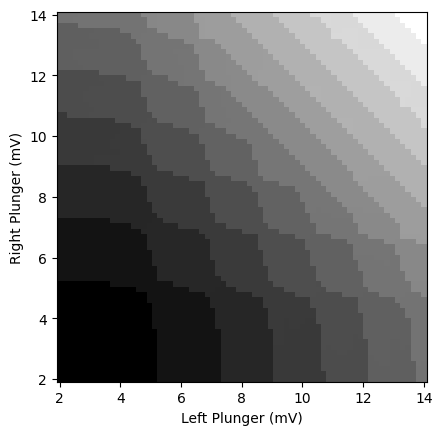

In [4]:
sensor_num = 0 # which sensor to use (by default there's only one,
               # but you can add more by changing phys.sensors)

# Obtain the sensor readout as a numpy array with shape (x_resolution, y_resolution)
sensor_data = csd.sensor[:,:,sensor_num]

# Plot the results
fig, ax = plt.subplots()
tutorial_helper.plot_csd_data(fig, ax, sensor_data, x_y_vals=(csd.V_x, csd.V_y))

We can also obtain the ground-truth labels for the charge state of each pixel
in the diagram.

There are three seperate labels:

* `csd.are_dots_occupied` gives a boolean numpy array with shape
`(x_resolution, y_resolution, num_dots)`. For each pixel `(x, y)` in the CSD,
this array tells whether a given dot has at least 1 charge.

* `csd.are_dots_combined` gives a boolean numpy array with shape
`(x_resolution, y_resolution, num_barriers)`. For each pixel `(x, y)`,
this array tells whether or not the dots on both sides of a given barrier are
combined together (the barrier voltage is too small).

* `csd.dot_charges` gives an integer numpy array with shape
`(x_resolution, y_resolution, num_dots)`. For each pixel `(x, y)`,
this array gives the number of charges in each dot.

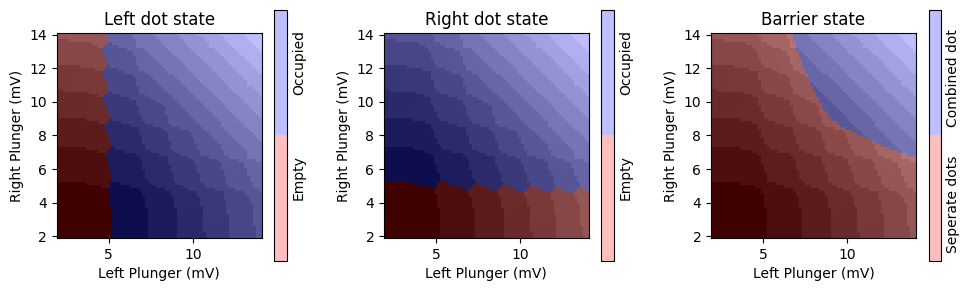

In [5]:
# Obtain dot occupation states
is_left_dot_occupied = csd.are_dots_occupied[:,:,0]
is_right_dot_occupied = csd.are_dots_occupied[:,:,1]

# Obtain barrier state
are_dots_combined = csd.are_dots_combined[:,:,0]

# Plot the results, overlayed with the sensor data
fig, ax = plt.subplots(1, 3, figsize=(10,3))
for i in range(3):
    tutorial_helper.plot_csd_data(fig, ax[i], sensor_data, x_y_vals=(csd.V_x, csd.V_y))
ax[0].set_title("Left dot state")
tutorial_helper.overlay_boolean_data(fig, ax[0], is_left_dot_occupied,
                x_y_vals=(csd.V_x, csd.V_y), labels=("Empty", "Occupied"))
ax[1].set_title("Right dot state")
tutorial_helper.overlay_boolean_data(fig, ax[1], is_right_dot_occupied,
                x_y_vals=(csd.V_x, csd.V_y), labels=("Empty", "Occupied"))
ax[2].set_title("Barrier state")
tutorial_helper.overlay_boolean_data(fig, ax[2], are_dots_combined,
                x_y_vals=(csd.V_x, csd.V_y), labels=("Seperate dots", "Combined dot"))
fig.tight_layout()

The transitions can be obtained from these charge states using
`generate.calc_transitions()`.

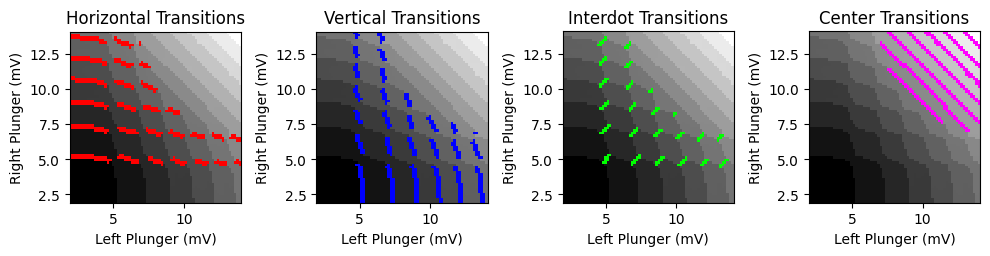

In [6]:
# Calculate transitions from charge states
is_transition, is_transition_combined = generate.calc_transitions(
                            csd.dot_charges, csd.are_dots_combined)


# Vertical transitions occur when there is a transition
# in the left dot but NOT the right dot
vertical_transitions = is_transition[:,:,0] & ~is_transition[:,:,1]

# Horizontal transitions occur when there is a transition
# in the right dot but NOT the left dot
horizontal_transitions = ~is_transition[:,:,0] & is_transition[:,:,1]

# Interdot transitions occur when there is a transition
# in both dots but they are NOT combined together
interdot_transitions = (is_transition[:,:,0] & is_transition[:,:,1]
                        & ~is_transition_combined[:,:,0])

# Center transitions occur when there is a transition in a combined center dot
center_transitions = is_transition_combined[:,:,0]


# Plot the results, overlayed with the sensor data
fig, ax = plt.subplots(1, 4, figsize=(10,2.5))
for i in range(4):
    tutorial_helper.plot_csd_data(fig, ax[i], sensor_data, x_y_vals=(csd.V_x, csd.V_y))
ax[0].set_title("Horizontal Transitions")
tutorial_helper.overlay_boolean_data(fig, ax[0], horizontal_transitions,
                x_y_vals=(csd.V_x, csd.V_y), colors=((0,0,0,0),(1,0,0,1)))
ax[1].set_title("Vertical Transitions")
tutorial_helper.overlay_boolean_data(fig, ax[1], vertical_transitions,
                x_y_vals=(csd.V_x, csd.V_y), colors=((0,0,0,0),(0,0,1,1)))
ax[2].set_title("Interdot Transitions")
tutorial_helper.overlay_boolean_data(fig, ax[2], interdot_transitions,
                x_y_vals=(csd.V_x, csd.V_y), colors=((0,0,0,0),(0,1,0,1)))
ax[3].set_title("Center Transitions")
tutorial_helper.overlay_boolean_data(fig, ax[3], center_transitions,
                x_y_vals=(csd.V_x, csd.V_y), colors=((0,0,0,0),(1,0,1,1)))
fig.tight_layout()

# Generating Datasets

QDFlow is capable of generating large, diverse datasets. To do this, we need to
generate many sets of randomized physics parameters. This is accomplished
through the `PhysicsRandomization` dataclass, which defines distributions from
which each physics parameter is drawn.

In [1]:
from qdflow import generate
import tutorial_helper
from qdflow.util import distribution
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create a randomization object with default distributions for each parameter
phys_rand = generate.PhysicsRandomization.default()

# Print out some of the default distributions
print("Screening Length: %s" % str(phys_rand.screening_length))
print("Gate Radius: %s" % str(phys_rand.rho))

Screening Length: distribution.LogUniform(75, 150)
Gate Radius: distribution.Uniform(10, 20)


Variable ranges can be adjusted by setting a parameter to a new distribution,
or to a specific value if no randomization is desired.

In [3]:
# Change the distribution from which the screening length is drawn
phys_rand.screening_length = distribution.Normal(100, 20)

# Set the gate radius to a constant (will not be randomized)
phys_rand.rho = 15

Now randomized sets of physics parameters can be drawn as desired from these
distributions.

In [4]:
generate.set_rng_seed(1) # Rng seed set for reproducibility

n_devices = 6 # How many randomized parameter sets to generate

# Generate a list of randomized sets of physics parameters
phys_params = generate.random_physics(phys_rand, n_devices)

Then, all that is required is to run the simulation with each of the physics
parameter sets.

In [5]:
# Smaller ranges and resolution used for the sake of time
V_x = np.linspace(3., 11., 50)
V_y = np.linspace(3., 11., 50)

# Run the simulation, this may take ~ 40 seconds
csds = [generate.calc_2d_csd(phys, V_x, V_y) for phys in phys_params]

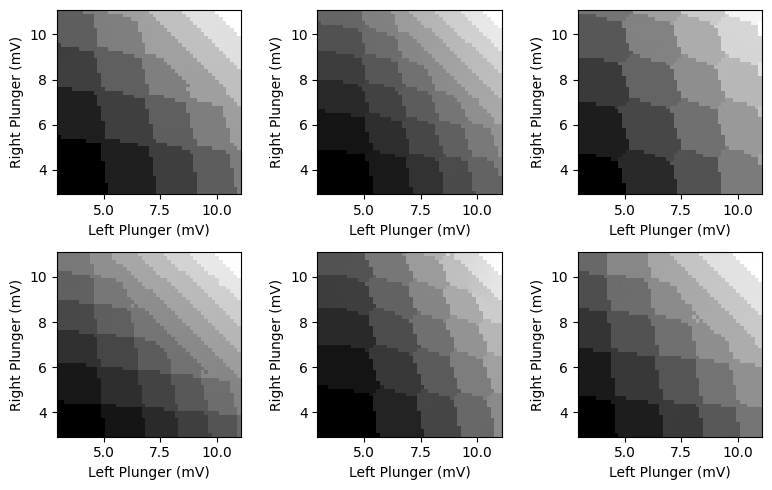

In [6]:
# Plot the results
fig, ax = plt.subplots(2, 3, figsize=(8,5))
ax = ax.flatten()
for i in range(6):
    tutorial_helper.plot_csd_data(fig, ax[i], csds[i].sensor[:,:,0], x_y_vals=(csds[i].V_x, csds[i].V_y))
fig.tight_layout()

# Distributions

QDFlow allows you to specify exactly how parameters are randomized.
This is done through the `Distribution` class.

Several basic distributions are provided (which are essentially wrappers of the
numpy random functions), and QDFlow also allows for the definition of custom
distributions if more complex behavior is needed.

In [1]:
import tutorial_helper
from qdflow.util import distribution
import numpy as np
import matplotlib.pyplot as plt

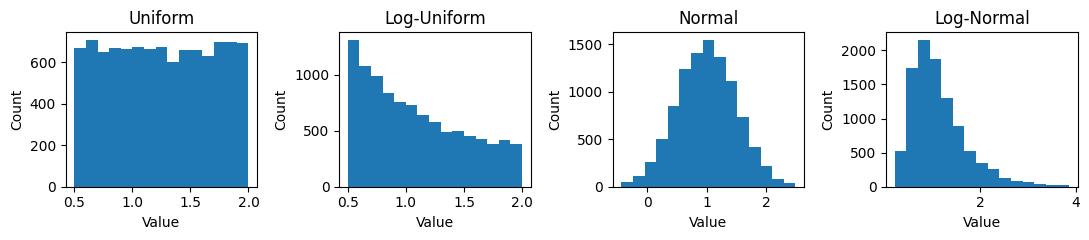

In [2]:
# Simple distributions built into QDFlow
uniform_dist = distribution.Uniform(0.5, 2)
log_uniform_dist = distribution.LogUniform(0.5, 2)
normal_dist = distribution.Normal(1, 0.5)
log_normal_dist = distribution.LogNormal(0, 0.5)

dists = [uniform_dist, log_uniform_dist, normal_dist, log_normal_dist]

num_samples = 10000 # How many times to sample from each distribution

rng = np.random.default_rng(seed=2)

# Sample from each distribution
samples = [dist.draw(rng, num_samples) for dist in dists]

# Plot results
fig, ax = plt.subplots(1, 4, figsize=(11,2.5))
for i in range(4):
    tutorial_helper.plot_dist_data(fig, ax[i], samples[i], bins=15)
    ax[i].set_title(["Uniform","Log-Uniform","Normal","Log-Normal"][i])
fig.tight_layout()

Distributions can be combined with basic arithmetic operations +, -, *, and /.
This has the effect of drawing from each distribution and performing the
arithmetic operation on the resulting values.
The absolute value can also be taken with `dist.abs()`.

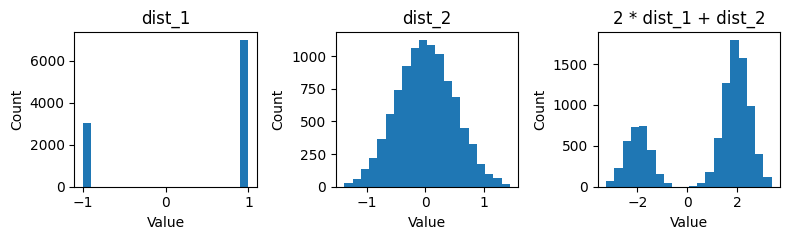

In [3]:
# Simple distributions built into QDFlow
dist_1 = distribution.Binary(.7, 1, -1)
dist_2 = distribution.Normal(0, 0.5)

# Define a new distribution by using arithmetic operators on the first two
dist_3 = 2 * dist_1 + dist_2

dists = [dist_1, dist_2, dist_3]

num_samples = 10000 # How many times to sample from each distribution

rng = np.random.default_rng(seed=3)

# Sample from each distribution
samples = [dist.draw(rng, num_samples) for dist in dists]

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(8,2.5))
for i in range(3):
    tutorial_helper.plot_dist_data(fig, ax[i], samples[i], bins=20)
    ax[i].set_title(["dist_1","dist_2","2 * dist_1 + dist_2"][i])
fig.tight_layout()

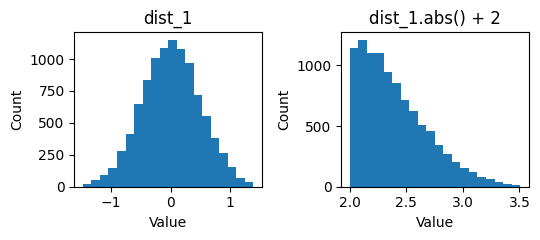

In [4]:
# Simple distribution built into QDFlow
dist_1 = distribution.Normal(0, 0.5)

# Define a new distribution by using arithmetic operators on the first one
dist_2 = dist_1.abs() + 2

dists = [dist_1, dist_2]

num_samples = 10000 # How many times to sample from each distribution

rng = np.random.default_rng(seed=4)

# Sample from each distribution
samples = [dist.draw(rng, num_samples) for dist in dists]

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(5.5,2.5))
for i in range(2):
    tutorial_helper.plot_dist_data(fig, ax[i], samples[i], bins=20)
    ax[i].set_title(["dist_1", "dist_1.abs() + 2"][i])
fig.tight_layout()

# Custom Distributions

If the predefined distributions in QDFlow are insufficient, you can create your
own distributions. To do this, you will need to extend the `Distribution` class
and implement the `draw()` method.

In [1]:
import tutorial_helper
from qdflow.util import distribution
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define a custom distribution
class ChiSquare(distribution.Distribution):

    # The init method should store any parameters that define the distribution
    def __init__(self, degrees_freedom):
        self.df = degrees_freedom

    # The draw() method should return a single value if size is None,
    # or a numpy array with shape size, if size is an int or tuple of ints
    def draw(self, rng, size=None):
        if size is None:
            return rng.chisquare(self.df)
        else:
            return rng.chisquare(self.df, size=size)

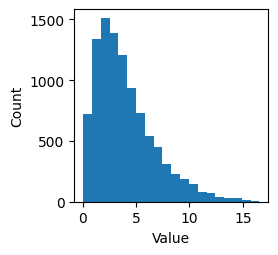

In [3]:
# Create an instance of the custom distribution
custom_dist = ChiSquare(4)

num_samples = 10000 # How many times to sample from each distribution

rng = np.random.default_rng(seed=5)

samples = custom_dist.draw(rng, num_samples)

# Plot results
fig, ax = plt.subplots(figsize=(2.5,2.5))
tutorial_helper.plot_dist_data(fig, ax, samples, bins=20)

# Correlated Distributions

Occasionally, you may want to randomize multiple variables subject to some
specific constraints.

* When randomizing physics parameters, you may want `V_L` and `V_R`
to be randomized subject to the constraint that `V_L == -V_R`.

* When adding noise, you may want to randomize the strengths of two
different noise types, such that their sum is always a certain value.

This can be accomplished through any of the `CorrelatedDistribution` classes
provided with QDFlow, or by creating a custom `CorrelatedDistribution`.

In [1]:
from qdflow.util import distribution
import numpy as np
from qdflow import generate

A `CorrelatedDistribution` is essentially a multivariate distribution, where
the variables are correlated in some way. A single draw from a
`CorrelatedDistribution` will return an array of length `num_variables`.

The simplest `CorrelatedDistribution` included in QDFlow is `FullyCorrelated`,
which simply returns a number of copies of the same value.

In [2]:
dist_single = distribution.Normal(20, 5) # A single-variable distribution

# A correlated distribution that returns 5 copies of the same value
num_variables = 5
corr_dist = distribution.FullyCorrelated(dist_single, num_variables)

rng = np.random.default_rng(seed=6)

# Draw a single sample of each of the 5 variables
single_sample = corr_dist.draw(rng)
print("Single sample: ", single_sample)

# Draw multiple samples of each variable
num_samples = 3
samples = corr_dist.draw(rng, size=num_samples)
print("Multiple samples:\n", samples)

Single sample:  [25.26557877 25.26557877 25.26557877 25.26557877 25.26557877]
Multiple samples:
 [[28.88245652 28.88245652 28.88245652 28.88245652 28.88245652]
 [ 7.23354081  7.23354081  7.23354081  7.23354081  7.23354081]
 [19.31017469 19.31017469 19.31017469 19.31017469 19.31017469]]


When performing randomization, QDFlow expects each field in the randomization
class to be given a seperate distribution.

Distributions for each of the individual variables can be obtained from a
`CorrelatedDistribution` via the `dependent_distributions()` method.

In [3]:
# Create a correlated distribution with 2 variables
dist_single = distribution.Normal(0, 1)
num_variables = 2
corr_dist = distribution.FullyCorrelated(dist_single, num_variables)

# Obtain a list [dist_1, dist_2] of the individual distributions for each variable
individual_dists = corr_dist.dependent_distributions()
dist_1, dist_2 = individual_dists

rng = np.random.default_rng(seed=7)

# Draw a single sample from one of the individual distributions
sample_1 = dist_1.draw(rng)
print("Sample 1: ", sample_1)

# Now draw a sample from the other individual distribution
sample_2 = dist_2.draw(rng)
print("Sample 2: ", sample_2)

Sample 1:  0.0012301533574825742
Sample 2:  0.0012301533574825742


These individual distributions can then be used to specify how physics
parameters should be randomized.

In [4]:
# Create a randomization object with default distributions for each parameter
phys_rand = generate.PhysicsRandomization.default()

# Set V_L and V_R distributions such that they will always be negative of each other.
phys_rand.V_L = 2 * dist_1
phys_rand.V_R = -2 * dist_2

# Generate a randomized set of physics parameters
generate.set_rng_seed(8)
n_devices = 6
phys_params = generate.random_physics(phys_rand, n_devices)
print("V_L: ", phys_params[0].V_L)
print("V_R: ", phys_params[0].V_R)

V_L:  -0.37779439216921556
V_R:  0.37779439216921556


# Adding Noise

In order to generate realistic data, we need to add noise to the CSDs after they
have been generated.

First, we'll generate a sample CSD to add noise to.

In [1]:
from qdflow import generate
import tutorial_helper
import numpy as np
import matplotlib.pyplot as plt
from qdflow.physics import noise

In [2]:
# Generate a sample CSD to add noise to, this may take ~ 20 seconds
phys = generate.default_physics(n_dots=2)
V_x = np.linspace(3., 12., 80)
V_y = np.linspace(3., 12., 80)
csd = generate.calc_2d_csd(phys, V_x, V_y)

Now we want to randomize the strengths of different types of noise to add.
This is done using the `NoiseRandomization` class.

In [3]:
# Create a randomization object with default distributions for each parameter
noise_rand = noise.NoiseRandomization.default()

# Print out some of the default distributions
print("White Noise Magnitude: %s" % str(noise_rand.white_noise_magnitude))
print("Amount of Latching: %s" % str(noise_rand.latching_pixels))

White Noise Magnitude: distribution.Uniform(0.08, 0.12)
Amount of Latching: (distribution.Normal(1, 0.3)).abs()


We can then sample each of the distributions and obtain a `NoiseParameters` instance, which defines the magnitude and other parameters for each type of noise.
In general, you will want a seperate `NoiseParameters` instance for each CSD.

In [4]:
noise.set_rng_seed(9)

# Obtain a set of noise parameters by drawing from the noise_rand distributions.
noise_params = noise.random_noise_params(noise_rand)

# Print out some of the noise parameter values
print("White Noise Magnitude: %s" % str(noise_params.white_noise_magnitude))
print("Amount of Latching: %s" % str(noise_params.latching_pixels))

White Noise Magnitude: 0.11480996815880339
Amount of Latching: 1.1291457236662927


Then noise can be added to a CSD using `NoiseGenerator.calc_noisy_map()`.

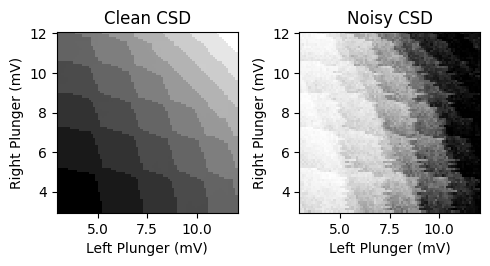

In [5]:
clean_data = csd.sensor[:,:,0]

noise.set_rng_seed(10)

# Add noise to the CSD
noisy_data = noise.NoiseGenerator(noise_params).calc_noisy_map(clean_data)

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(5,2.7))
tutorial_helper.plot_csd_data(fig, ax[0], clean_data, x_y_vals=(csd.V_x, csd.V_y))
ax[0].set_title("Clean CSD")
tutorial_helper.plot_csd_data(fig, ax[1], noisy_data, x_y_vals=(csd.V_x, csd.V_y))
ax[1].set_title("Noisy CSD")
fig.tight_layout()

You can turn specific noise types on or off when adding noise.

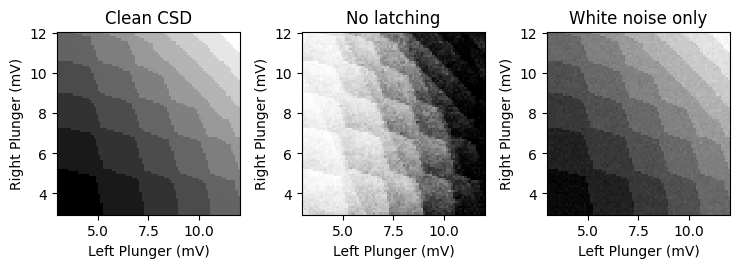

In [6]:
noise.set_rng_seed(11)

# Turn off latching
no_latching = noise.NoiseGenerator(noise_params).calc_noisy_map(
        clean_data, latching=False)

# Use white noise only
white_noise_only = noise.NoiseGenerator(noise_params).calc_noisy_map(
        clean_data, noise_default=False, white_noise=True)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(7.5,2.7))
tutorial_helper.plot_csd_data(fig, ax[0], clean_data, x_y_vals=(csd.V_x, csd.V_y))
ax[0].set_title("Clean CSD")
tutorial_helper.plot_csd_data(fig, ax[1], no_latching, x_y_vals=(csd.V_x, csd.V_y))
ax[1].set_title("No latching")
tutorial_helper.plot_csd_data(fig, ax[2], white_noise_only, x_y_vals=(csd.V_x, csd.V_y))
ax[2].set_title("White noise only")
fig.tight_layout()

Latching is implemented in two different ways:

* The simple latching method is performed by shifting each row
by a random number of pixels.

* The excited-state latching method involves replacing pixels with excited state
data for several pixels after each transition.

The excited-state latching method is more realistic, but requires additional data
about the excited states and transitions.

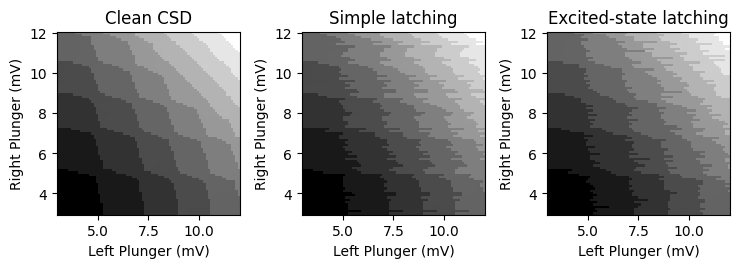

In [7]:
noise.set_rng_seed(12)

# Increase the latching amount for demonstration purposes
noise_params_2 = noise_params.copy()
noise_params_2.latching_pixels = 1.7

# Simple latching is used if no additional data is provided
simple_latching = noise.NoiseGenerator(noise_params_2).calc_noisy_map(
        clean_data, noise_default=False, latching=True)

# Excited-state latching requires excited state data, charge states,
# and whether dots are combined
excited_data = csd.excited_sensor[:,:,0]
dot_charges = csd.dot_charges
are_dots_combined = csd.are_dots_combined

excited_latching = noise.NoiseGenerator(noise_params_2).calc_noisy_map(
        clean_data, latching_data=(excited_data, dot_charges, are_dots_combined),
        noise_default=False, latching=True)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(7.5,2.7))
tutorial_helper.plot_csd_data(fig, ax[0], clean_data, x_y_vals=(csd.V_x, csd.V_y))
ax[0].set_title("Clean CSD")
tutorial_helper.plot_csd_data(fig, ax[1], simple_latching, x_y_vals=(csd.V_x, csd.V_y))
ax[1].set_title("Simple latching")
tutorial_helper.plot_csd_data(fig, ax[2], excited_latching, x_y_vals=(csd.V_x, csd.V_y))
ax[2].set_title("Excited-state latching")
fig.tight_layout()

Note for simple latching, the latching pattern repeats for each transition,
whereas for excited-state latching, the latching pattern is unique for each transition.

# Ray Data

There is research about using 1D rays to explore CSDs rather than taking a full
2D CSD scan.

QDFlow contains built-in functions for generating data along 1D rays for these
applications.

In [1]:
from qdflow import generate
import tutorial_helper
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

In [2]:
# Generate a full CSD to aid in visualization, this may take ~ 20 seconds
phys = generate.default_physics(n_dots=2)
V_x = np.linspace(0., 15., 80)
V_y = np.linspace(0., 15., 80)
csd = generate.calc_2d_csd(phys, V_x, V_y)

Rays are generated starting from a central point, and extending outward in
various directions.

First we will create a list of central points from which to build the rays.
We will use a sample of quasirandom points; however, points can be selected in
any manner you choose.

Then we will define the rays as an array of displacement vectors
`[delta_x, delta_y]` that will all be added to each central point.

In [3]:
# Generate quasirandom points inside a given area
v_min, v_max = 3., 12.
num_points = 10
point_generator = qmc.Halton(d=2, scramble=False)
initial_points = qmc.scale(point_generator.random(n=num_points), v_min, v_max)

# Define a list of rays that will extend out from each point
ray_length = 3. # length of rays in mV
num_rays = 8
rays = ray_length * np.array([[np.cos(2*np.pi*i/num_rays),
                    np.sin(2*np.pi*i/num_rays)] for i in range(num_rays)])

Now the ray data can be generated using `generate.calc_rays()`.

The results will be returned in an instance of the `RaysOutput` dataclass,
which is similar to the `CSDOutput` dataclass we have been using so far.

In [4]:
resolution = 50 # points per ray

# Generate ray data, this may take ~ 10 seconds
ray_output = generate.calc_rays(phys, initial_points, rays, resolution)

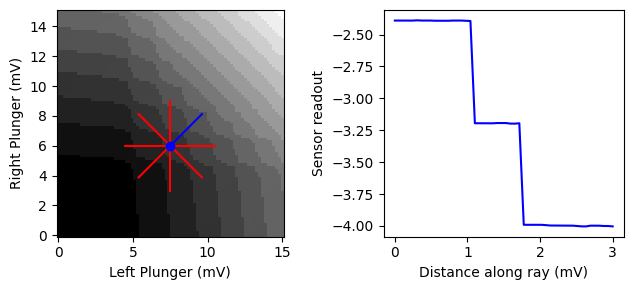

In [5]:
# Change these to show different plots
point_num_to_plot = 1 # Must be between 0 and num_points (10)
ray_num_to_plot = 1 # Must be between 0 and num_rays (8)

ray_data = ray_output.sensor[point_num_to_plot, ray_num_to_plot, :, 0]

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(6.5,3))
tutorial_helper.plot_csd_data(fig, ax[0], csd.sensor[:,:,0], x_y_vals=(csd.V_x, csd.V_y))
tutorial_helper.overlay_rays(fig, ax[0], ray_output.centers[point_num_to_plot],
                             ray_output.rays, ray_num_to_plot)
ax[1].plot(np.linspace(0, np.linalg.norm(ray_output.rays[ray_num_to_plot]),
                       ray_output.resolution), ray_data, color="blue")
ax[1].set_xlabel("Distance along ray (mV)")
ax[1].set_ylabel("Sensor readout")
fig.tight_layout()

# Physics Simulation

Finally, we will take a close look at the physics simulation at the core of QDFlow.

This is not necessary for generating data, but hopefully will offer some insight
into how the simulation works and what the physics parameters do.

In [1]:
from qdflow.physics import simulation
from qdflow import generate
import tutorial_helper
import numpy as np
import matplotlib.pyplot as plt

The main part of the simulation is the `ThomasFermi` class.

The simulation is performed via a series of static methods. For each method, all
relevant data must be provided as the function's arguments.

This includes a `PhysicsParameters` instance (which defines the physical
parameters of the system), as well as a `NumericsParameters` instance
(which is used to set numerical options).

The `ThomasFermi` class contains a convenience method `run_calculations()`,
which runs all the necessary methods to perform the simulation. However, we will
not use it here, instead walking through the main steps of the simulation in detail.

In [2]:
# Define a set of default physical and numerical parameters
phys = generate.default_physics(n_dots=2)
numerics = simulation.NumericsParameters()
phys.gates[3].peak = 7.5 # Adjust a gate voltage value

# The simulation could be run all at once with the following code:

# tf = simulation.ThomasFermi(phys, numerics=numerics)
# tf_out = tf.run_calculations()

QDFlow uses a nanowire model, where charges are confined to a 1D nanowire
which lies along the x-axis.

A set of cylindrical gates induce a potential V(x) along the nanowire.

The first step in the simulation is to calculate V(x) based on the voltages and
layout of the gates. Alternatively, V(x) can be supplied directly as part of the
`PhysicsParameters` dataclass, in which case this part of the simulation is skipped.

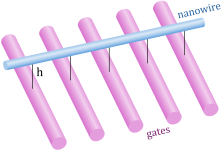


Each gate has its own position, radius, screening length, and voltage, which are
stored in instances of the `GateParameters` dataclass.

Note that the voltage given by `GateParameters.peak`, is the peak voltage
induced by the gate along the nanowire (the maximum of V(x) in the absence of
other gates), **not the voltage of the gate itself**.

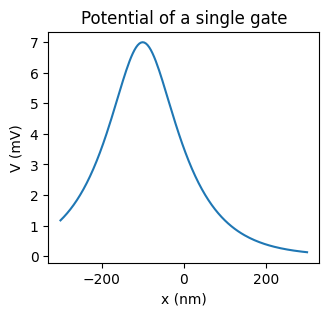

In [3]:
# Get one of the gates from the sample physics parameters 
gate_params = phys.gates[1]

# Calculate the potential along the nanowire due to a single gate
x = phys.x
V_gate = simulation.calc_V_gate(gate_params, x, 0, 0)

# Plot the result
fig, ax = plt.subplots(figsize=(3.5,3))
ax.plot(x, V_gate)
ax.set_xlabel("x (nm)")
ax.set_ylabel("V (mV)")
ax.set_title("Potential of a single gate");

When multiple gates are in close proximity, the charge from one gate can induce
additional charges on the other gates. QDFlow attempts to correct for this
effect, assuming that the induced charges are cylidrically symmetric, allowing
us to replace the gate voltage with an effective voltage which includes the
induced charges.

In [4]:
# Get list of gate voltages from the sample physics parameters 
gates = phys.gates
gate_voltages = np.array([gate.peak for gate in gates])
print("Gate voltages:", gate_voltages)

# Calculate correction matrix to account for induced charges
gate_matrix = simulation.calc_effective_peak_matrix(gates)

# Calculate effective gate voltages due to induced charges
effective_voltages = np.dot(gate_matrix, gate_voltages)
print("Effective voltages:", effective_voltages)

Gate voltages: [-7.   7.  -5.   7.5 -7. ]
Effective voltages: [-8.76084453 10.09547469 -8.3128789  10.64644697 -8.86626613]


When calculating the potential via `calc_V()`, this will be calculated automatically.

If you wish to not take into account induced charges, you can use the keyword arg
`effective_peak_matrix=np.identity(len(gates))`. This will essentially treat
the gates as a nonconducting static line charge.

`phys.q` is the sign of the charges (-1 for electrons, +1 for holes). From here
on, we shall plot the potential energy q * V, rather than V(x) directly.

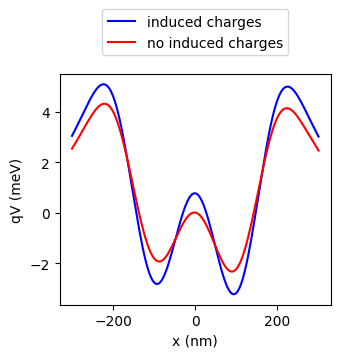

In [5]:
# Calculate V(x) from the gates
gates = phys.gates
x = phys.x
V = simulation.calc_V(gates, x, 0, 0)

# Calculate V(x) assuming no induced charges
V_no_induced_charge = simulation.calc_V(gates, x, 0, 0,
                      effective_peak_matrix=np.identity(len(gates)))

q = phys.q # Get the sign of the charges

# Plot the results
fig, ax = plt.subplots(figsize=(3.5,3))
tutorial_helper.plot_potential(fig, ax, x, q*V, color="blue")
tutorial_helper.plot_potential(fig, ax, x, q*V_no_induced_charge, color="red")
ax.legend(["induced charges","no induced charges"], loc="lower center", bbox_to_anchor=(0.5, 1.05))

Now we must also calculate the Coulomb interaction matrix K(x, x').
Alternatetively, K(x, x') can be supplied directly as part of the `PhysicsParameters`
dataclass, in which case this next step is skipped.

By default, K(x, x') is calculated using the formula:

$K(x, x') = \frac{K_0}{\sqrt{(x-x')^2 + \sigma^2}}$.

Here $\sigma$ is a softening parameter which prevents K(x, x') from blowing up
when (x - x') is small or zero. This numerical issue occurs because our
simulation is 1D, which assumes an intinitessimally thin nanowire. In reality,
however, the nanowire has some finite width, which prevents K(x, x') from blowing
up. Thus, $\sigma$ should be chosen to be on the order of the width of the nanowire.

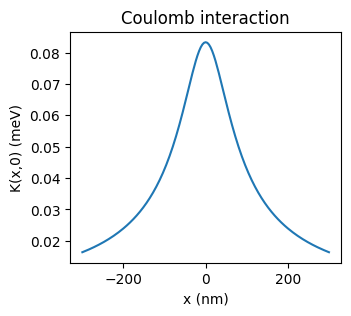

In [6]:
# Get sample physics parameters
x = phys.x
K_0 = phys.K_0
sigma = phys.sigma

# Calculate the Coulomb interaction matrix
K_mat = simulation.calc_K_mat(x, K_0, sigma)

# Plot the result
fig, ax = plt.subplots(figsize=(3.5,3))
ax.plot(x, K_mat[:, len(x)//2])
ax.set_xlabel("x (nm)")
ax.set_ylabel("K(x,0) (meV)")
ax.set_title("Coulomb interaction");

# Thomas-Fermi Solver

Now we will take a look at the Thomas-Fermi solver. This solver attempts to solve the following integral equation for the charge
density n(x):

$n(x) = \frac{g_0}{\beta}\;\text{sp}[\beta(\mu-qV(x)-{\bf K}\cdot n(x))]$

Here $g_0$ is the density of states, $\mu$ is the Fermi level, and $\beta$ is the
inverse temperature. These parameters can all be changed in the `PhysicsParameters`
dataclass. $\text{sp}(z) = \ln(1+e^z)$ is the softplus function.

In [1]:
from qdflow.physics import simulation
from qdflow import generate
import tutorial_helper
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define a set of default physical and numerical parameters
phys = generate.default_physics(n_dots=2)
phys.gates[3].peak = 7.5
x = phys.x
q = phys.q
numerics = simulation.NumericsParameters()

# Calculate V(x) and K(x, x')
V = simulation.calc_V(phys.gates, x, 0, 0)
K_mat = simulation.calc_K_mat(x, phys.K_0, phys.sigma)

Additionally, the Thomas-Fermi solver requires the following matrix in order to
help with convergence issues which we shall discuss later:

$[g_0 \delta_x {\bf K} + {\bf 1}]^{-1}$,

where $\delta_x$ is the resolution with which the x-axis has been discretized,
and ${\bf 1}$ is the identity matrix.

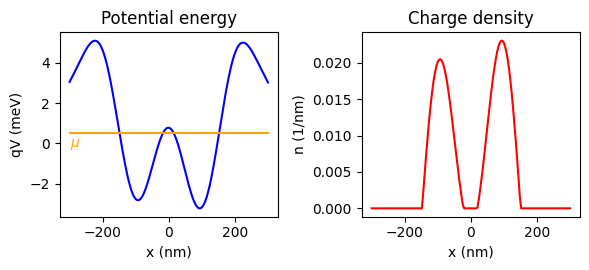

In [3]:
# Calculate the inverse of [g_0 delta_x K_mat + 1]
delta_x = x[1] - x[0]
g0_dx_K_plus_1_inv = np.linalg.inv(phys.g_0 * delta_x * K_mat + np.identity(len(x)))

# Run the Thomas-Fermi solver
# This may take a few seconds initially due to numba compilation time
n, phi, converged = simulation.ThomasFermi.calc_n(phys, numerics, V, K_mat, g0_dx_K_plus_1_inv)

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(6,2.8))
tutorial_helper.plot_potential(fig, ax[0], x, q*V, mu=phys.mu)
tutorial_helper.plot_n(fig, ax[1], x, n)
ax[0].set_title("Potential energy")
ax[1].set_title("Charge density")
fig.tight_layout()


The Thomas-Fermi solver uses a successive iteration method to find n(x).
This involves starting with some "guess" $n_0(x)$ (by default zero is used),
and evaluating the integral equation above to find an updated function $n_1(x)$.

This process is then repeated until one of the following occurs:
* A maximum number of iterations is reached
* The difference $\Delta_n = n_i(x) - n_{i-1}(x)$ lies below some absolute tolerance,
satisfying $|\Delta_n| \delta_x < \text{abs}\_\text{tol}$
* $\Delta_n$ lies below some relative tolerance, satisfying
$|\Delta_n| < \text{rel}\_\text{tol} \sqrt{|n_{i-1}|*|n_i|}$

For the sake of illustration, we'll show the successive iteration method without
any additional improvements, which can be done by setting
`NumericsParameters.calc_n_use_combination_method` to False.

C:\Users\dlb8\OneDrive - NIST\Documents\qdflow_paper\QDFlow-sim\src\qdflow\physics\simulation.py:1632: ConvergenceWarning: ThomasFermi.calc_n() failed to converge.
  warnings.warn("ThomasFermi.calc_n() failed to converge.",


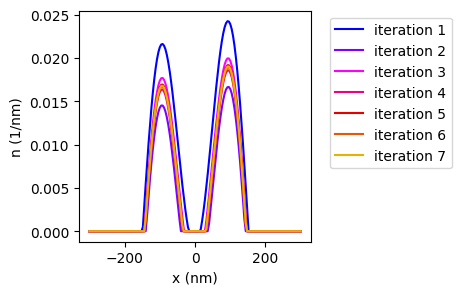

In [4]:
# Use physics parameters with a somewhat larger K_0
phys_high_K = generate.default_physics(n_dots=2)
phys_high_K.K_0 = 30
phys_high_K.gates[3].peak = 7.5
x = phys_high_K.x
q = phys_high_K.q

# Set numerics parameters to use basic method only
# and to run for the full number of iterations
numerics_basic = simulation.NumericsParameters()
numerics_basic.calc_n_use_combination_method = False
numerics_basic.calc_n_abs_tol = 0
numerics_basic.calc_n_rel_tol = 0

V = simulation.calc_V(phys_high_K.gates, x, 0, 0)
K_mat = simulation.calc_K_mat(x, phys_high_K.K_0, phys_high_K.sigma)

# Find n(x) using a different number of iterations each time
num_iterations = 7
n_result = np.zeros((num_iterations, len(x)))
for i in range(num_iterations):
    numerics_basic.calc_n_max_iterations_no_guess = i + 1
    n, phi, converged = simulation.ThomasFermi.calc_n(phys_high_K, numerics_basic, V, K_mat, None)
    n_result[i,:] = n

# Plot the results
fig, ax = plt.subplots(figsize=(3, 3))
tutorial_helper.plot_n(fig, ax, x, n_result)

Here we see the function n(x) oscillating around for a bit before converging to
the center.

Note that we get a `ConvergenceWarning`. This is because we have intentially set
the maximum number of iterations to be small so that we can track the convergence
of the method.

Now let's try again with a larger value of K_0.

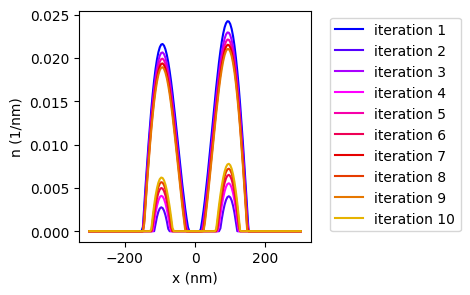

In [5]:
# Use physics parameters with a much larger K_0
phys_high_K = generate.default_physics(n_dots=2)
phys_high_K.K_0 = 80
phys_high_K.gates[3].peak = 7.5
x = phys_high_K.x
q = phys_high_K.q

# Set numerics parameters to use basic method only
# and to run for the full number of iterations
numerics_basic = simulation.NumericsParameters()
numerics_basic.calc_n_use_combination_method = False
numerics_basic.calc_n_abs_tol = 0
numerics_basic.calc_n_rel_tol = 0

V = simulation.calc_V(phys_high_K.gates, x, 0, 0)
K_mat = simulation.calc_K_mat(x, phys_high_K.K_0, phys_high_K.sigma)

# Find n(x) using a different number of iterations each time
num_iterations = 10
n_result_basic = np.zeros((num_iterations, len(x)))
for i in range(num_iterations):
    numerics_basic.calc_n_max_iterations_no_guess = i + 1
    n, phi, converged = simulation.ThomasFermi.calc_n(phys_high_K, numerics_basic, V, K_mat, None)
    n_result_basic[i,:] = n

# Plot the results
fig, ax = plt.subplots(figsize=(3, 3))
tutorial_helper.plot_n(fig, ax, x, n_result_basic)

Here n(x) appears to be oscillating between 2 values and converging very slowly,
if at all. In general, as K_0 gets larger, convergence becomes more problematic.

We can help out a bit by using the improved method discussed in
[arXiv:2509.13298](https://arxiv.org/abs/2509.13298).
The old method simply updates n(x) each iteration to be
the result of evaluating the integral equation
$n_1(x) = \frac{g_0}{\beta}\;\text{sp}[\beta(\mu-qV(x)-{\bf K}\cdot n_0(x))]$.
The improved method instead sets $n(x)$ to a combination of $n_1(x)$ and $n_0(x)$
each iteration as follows:

$n(x) = [g_0 \delta_x {\bf K} + {\bf 1}]^{-1} [g_0 \delta_x {\bf K} n_0(x) + n_1(x)]$.

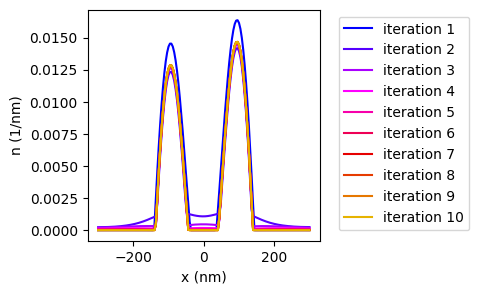

In [6]:
# Use the same example as above
phys_high_K = generate.default_physics(n_dots=2)
phys_high_K.K_0 = 80
phys_high_K.gates[3].peak = 7.5
x = phys_high_K.x
q = phys_high_K.q

# Use the default, improved method now
numerics_improved = simulation.NumericsParameters()
numerics_improved.calc_n_abs_tol = 0
numerics_improved.calc_n_rel_tol = 0

V = simulation.calc_V(phys_high_K.gates, x, 0, 0)
K_mat = simulation.calc_K_mat(x, phys_high_K.K_0, phys_high_K.sigma)

# Find n(x) using a different number of iterations each time
num_iterations = 10
n_result_improved = np.zeros((num_iterations, len(x)))
for i in range(num_iterations):
    numerics_improved.calc_n_max_iterations_no_guess = i + 1
    n, phi, converged = simulation.ThomasFermi.calc_n(phys_high_K, numerics_improved, V, K_mat, None)
    n_result_improved[i,:] = n

# Plot the results
fig, ax = plt.subplots(figsize=(3, 3))
tutorial_helper.plot_n(fig, ax, x, n_result_improved)

The improved method converges quite quickly. However, even this method has its
limits and will break down for very large $g_0 \delta_x {\bf K}$.

# Capacitance Model

After solving the Thomas-Fermi equations for n(x), QDFlow builds a capacitance
model to determine the dot occupancies.

In [1]:
from qdflow.physics import simulation
from qdflow import generate
import tutorial_helper
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define a set of default physical and numerical parameters
phys = generate.default_physics(n_dots=2)
phys.gates[3].peak = 7.5
x = phys.x
q = phys.q
numerics = simulation.NumericsParameters()

# Calculate V(x) and solve for n(x)
# This may take a few seconds initially due to numba compilation time
V = simulation.calc_V(phys.gates, x, 0, 0)
K_mat = simulation.calc_K_mat(x, phys.K_0, phys.sigma)
delta_x = x[1] - x[0]
g0_dx_K_plus_1_inv = np.linalg.inv(phys.g_0 * delta_x * K_mat + np.identity(len(x)))
n, phi, converged = simulation.ThomasFermi.calc_n(phys, numerics, V, K_mat, g0_dx_K_plus_1_inv)

The first step is identifying the regions in which charges are confined. This is
done by identifying charge "islands" for which n(x) is above some relative value.

This is the step that is responsible for determining whether the dots should be
handled individually, or as a single, combined center dot.

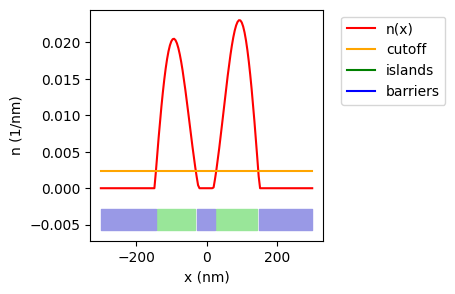

In [3]:
# A relative cutoff value is defined in the NumericsParameters dataclass
cutoff_value = numerics.island_relative_cutoff * np.max(n)

# Calculate the regions correcponding to islands and barriers
islands, barriers, all_islands, is_short_circuit = \
        simulation.ThomasFermi.calc_islands_and_barriers(phys, numerics, n)

# Plot the results
fig, ax = plt.subplots(figsize=(3,3))
tutorial_helper.plot_n(fig, ax, x, n)
tutorial_helper.plot_islands_and_barriers(fig, ax, x, n, islands, barriers, cutoff_value)
ax.legend(["n(x)","cutoff","islands","barriers"], bbox_to_anchor=(1.05, 1), loc='upper left');

Next, approximate charge occupancies $Z_i$ are calculated by integrating n(x) over
each charge island. Note that this will give a real number, not an integer
number of charges.

In [4]:
approx_charges = simulation.ThomasFermi.calc_approximate_charges(phys, n, islands)
print(approx_charges)

[1.53816277 1.80652947]


Now we build a capacitance model based off the result of n(x).

Specifically, we are interested in the energy matrix $E_{ij}$, which gives the
energy of an integer charge configuration $\vec{Q}$:

$E=\sum_{i,j}E_{ij}(Q_i-Z_i)(Q_j-Z_j)$

The energy matrix is found by calculating the average Coulomb potential energy
between dots i and j. Then an additional term is added along the diagonal to
account for the kinetic energy of charges in each dot. The strength of this
second term can be adjusted by changing `PhysicsParameters.c_k`.

In [5]:
# Calculate the energy matrix
energy_matrix = simulation.ThomasFermi.calc_energy_matrix(phys, numerics,
                K_mat, n, islands, approx_charges)
print("Energy matrix:\n", energy_matrix, "\n")

# Calculate and print out the energies of several charge configurations
configurations_to_check = np.array([[1,1], [1,2], [2,1], [2,2]], dtype=np.int_)
for config in configurations_to_check:
    energy = simulation.ThomasFermi.calc_cap_energy(config, energy_matrix, approx_charges)
    print("Energy of charge state", config, ": %0.5f" % energy)

Energy matrix:
 [[0.04923472 0.01370183]
 [0.01370183 0.04829884]] 

Energy of charge state [1 1] : 0.05757
Energy of charge state [1 2] : 0.01321
Energy of charge state [2 1] : 0.03171
Energy of charge state [2 2] : 0.01476


QDFlow uses a brute-force search of all integer charge configurations close to
`approx_charges` to determine which charge configuration has the lowest energy.

In [6]:
# Calculate the lowest-energy state
island_charges = simulation.ThomasFermi.calc_island_charges(numerics,
                 energy_matrix, approx_charges)
print("Lowest-energy state:", island_charges)

Lowest-energy state: [1 2]


This charge state vector has length equal to the number of charge islands.
However, the number of charge islands varies depending on n(x). For example:
* A double-dot has 2 islands, as seen above.
* There could be 1 island if the voltage of one of the plunger gates is reduced.
* There could be no islands if both plunger gates are reduced.
* If the barrier is reduced, there is only 1 central, combined charge island.
* There might be some other arrangment of islands for extreme / unconventional
choices of parameters or layouts with more than 2 dots.

When reporting data in a CSD, it is nice to standarize the length of the charge
state vector, so that the charge states for all points can be stored together 
in a single numpy `ndarray`.

Our solution is to set the length equal to the number of plunger gates (assuming
one plunger gate per dot). Then the charge islands are matched up to the closest
corresponding plunger. In the case of combined dots, all charges are placed in
the left-most entry, and a seperate variable is used to record that the dots are
combined together.

For example, a single island with 3 dots will have `island_charges == [3]`.
This can be expanded to length 2 in different ways, depending on where the
island is located:
* If the island is above the left plunger, it will become `[3, 0]`
* If the island is above the right plunger, it will become `[0, 3]`
* If the island is a single large, combined dot, it will become `[3, 0]`, and
`are_dots_combined` will be set to True to distinguish from the first case.

In [7]:
# Calculate the charge state
charge_centers = simulation.ThomasFermi.calc_charge_centers(phys, n, islands)
are_dots_occupied, are_dots_combined, dot_charges = \
        simulation.ThomasFermi.calc_dot_states(phys, islands, island_charges, charge_centers)
print("Charge state:", dot_charges)
print("are_dots_combined:", are_dots_combined)

Charge state: [1 2]
are_dots_combined: [False]


Finally, the sensor readout is calculated by calculating the screened potential
due to each of the charges at one or more sensor locations.

In [8]:
# Calculate sensor output
sensor_output = simulation.ThomasFermi.sensor_from_charge_state(phys, n,
        islands, dot_charges, are_dots_combined)
print("Single sensor output:", sensor_output)

# Calculate output for multiple sensors at a time
# Sensors should be provided as a numpy array with shape (num_sensors, 3)
# giving the (x, y, z) coordinates of each sensor
phys_multiple_sensors = phys.copy()
phys_multiple_sensors.sensors = np.array([[-200, 100, 0], [200, 100, 0]])
multi_sensor_output = simulation.ThomasFermi.sensor_from_charge_state(
        phys_multiple_sensors, n, islands, dot_charges, are_dots_combined)
print("Multiple sensor output:", multi_sensor_output)

Single sensor output: [-2.39504244]
Multiple sensor output: [-0.51501873 -0.90571996]
